# Correlations of crime and land use in Chicago

# Capstone project IBM Data Science

I would explore the correlations between the amount and types of crimes committed in a community area and the venues located there.  

The relations between crime and socioeconomic conditions are unclear. Often there are contradictory reports on whether difficult economic conditions create more crime or whether a booming economy that increases the availability of money and goods promotes crime. Nevertheless, it is important to do not dismiss possible connections between the economy and crime. In this project, I will try to find if the crimes committed in community areas with similar socioeconomic have a relation with the land use. For example, let's suppose that  A and B are community areas with similar economic conditions, but area A is much safer than area B. I want to see if the types of venues in area A are similar to those in area B. If they are not similar, then study what types of venues are present in the safer environment.  The venues could be parks, liquor shops, restaurants among others. 

Also, venues that reduce crime in one type of area do not necessarily affect crime in other types of areas.  One hypothesis here is that parks can be that kind of venue. In areas with a high rate of crime, social interactions can induce people to become criminals. Parks promote social interaction.  Therefore parks there contribute to crime. On the other hand, parks will not affect crime in areas with low rate crime. 

This project could help policymakers to design safer neighborhoods by building or closing venues to reduce crime. 

# Data

To reduce the effects of variables not considered in this project I will only compare neighborhoods in the same city.  Due to the availability of the data, I choose Chicago. The datasets of the crime and economic status of the neighborhoods in Chicago were already given in previous courses of this certification.   

In [1]:
import csv
import pandas as pd

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library
import numpy as np
import matplotlib.pyplot as plt

In [2]:
economic_data = pd.read_csv("Census_Data_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
economic_data.head(2)

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0


This dataset contain 9 parameters. I will only describe the ones that are not clear. 

**Percent of housing crowded**: Percentage of houses with more people than rooms.

**Percent households below poverty**: Percentage of houses with an income less than the federal poverty level. In 2012 it was an income of 23 050 for a family of 4.

**Hardship index**: It is an score that combines the 6 socioeconomic indicators in this dataset.

I plan to cluster the data set, to obtain similar socieconomic community areas.

In [3]:
crime_data=pd.read_csv("Chicago_Crime_Data.csv")
crime_data=crime_data.drop(["CASE_NUMBER","DATE","BLOCK","IUCR","BEAT","DISTRICT","WARD","X_COORDINATE","Y_COORDINATE","YEAR","UPDATEDON","LOCATION"], axis=1)
crime_data.head(2)

,ID,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,COMMUNITY_AREA_NUMBER,FBICODE,LATITUDE,LONGITUDE
0,3512276,THEFT,FROM BUILDING,SMALL RETAIL STORE,False,False,58.0,6,41.807441,-87.703956
1,3406613,THEFT,$500 AND UNDER,OTHER,False,False,23.0,6,41.898280,-87.716406


I only left the relevent information to project. That is the crimes, the types of crimes and their location. The **FBICODE** is a classification of crimes.

## Venues in a community area

To obtain the venues in an area, I need the location of the area. I will take the locaction of an area as the average location of the crimes within that area. 

In [4]:
location=crime_data.groupby(["COMMUNITY_AREA_NUMBER"]).mean()
location=location.drop(["ID","ARREST","DOMESTIC"], axis=1)
location.head(2)

,LATITUDE,LONGITUDE
COMMUNITY_AREA_NUMBER,,
1.0,42.013645,-87.673434
2.0,41.995488,-87.699195


I create a dataframe with community areas names, community area number, latitude and longitude.

In [5]:
location_name=pd.merge(economic_data,location, on="COMMUNITY_AREA_NUMBER")

In [6]:
location_name.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER_CAPITA_INCOME,HARDSHIP_INDEX,LATITUDE,LONGITUDE
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0,42.013645,-87.673434
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0,41.995488,-87.699195
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0,41.965424,-87.653356
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0,41.971693,-87.688144
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0,41.945273,-87.682741


I obtain the venues using the functions defined in the course.

In [7]:
CLIENT_ID = '3DUVJBPGEYCLZNSAIGXGADMURJJU5GSLR2KEQQHLU0IO2NZY' # your Foursquare ID
CLIENT_SECRET = 'RZ3O03B0L2QIKFWYPJKQCGPN4VEYAETNCM5SPQV0SZM13WOI' # your Foursquare Secret
VERSION = '20180605'

In [8]:
LIMIT = 50 # limit of number of venues returned by Foursquare API It was 100 originaly

radius = 500 # define radius

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['COMMUNITY_AREA_NAME', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
chicago_venues = getNearbyVenues(names=location_name['COMMUNITY_AREA_NAME'],
                                   latitudes=location_name['LATITUDE'],
                                   longitudes=location_name['LONGITUDE']
                                  )

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Norwood Park
Jefferson Park
Forest Glen
Albany Park
Portage Park
Irving Park
Dunning
Montclaire
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
Loop
Near South Side
Douglas
Fuller Park
Grand Boulevard
Kenwood
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Height
Morgan Park
O'Hare
Edgewater


In [17]:
print(chicago_venues.shape)
chicago_venues.head()

(1207, 7)


,COMMUNITY_AREA_NAME,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.013645,-87.673434,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
1,Rogers Park,42.013645,-87.673434,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
2,Rogers Park,42.013645,-87.673434,Romanian Kosher Sausage Co.,42.012765,-87.674692,Deli / Bodega
3,Rogers Park,42.013645,-87.673434,Pottawattomie Park,42.015112,-87.676928,Park
4,Rogers Park,42.013645,-87.673434,R Public House,42.016032,-87.668571,Sports Bar


The venues in each area are stored in the chicago_venues dataframe.

# Cluster the areas according to socioeconomic status

I divide the areas according to 6 parameters: 
  * Percent of housing crowded
  * Percent households below poverty
  * Percent aged 16+ unemployed
  * Percent aged 25+ without high school diploma
  * Percent aged under 18 or over 64
  * Per capita income
  
Except from Per capita income all the other variables are in the form of percentage. I will calculate the average income and change the column PER_CAPITA_INCOME to a percantage form.

In [18]:
location_name["PERCENT PER_CAPITA_INCOME"]=location_name["PER_CAPITA_INCOME "]/location_name["PER_CAPITA_INCOME "].mean()
location_name=location_name.drop(["PER_CAPITA_INCOME "], axis=1)
location_name.head(2)

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,HARDSHIP_INDEX,LATITUDE,LONGITUDE,PERCENT PER_CAPITA_INCOME
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,39.0,42.013645,-87.673434,0.930378
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,46.0,41.995488,-87.699195,0.895438


I look for the optimal number of cluster using the elbow method.

In [19]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(location_name[["PERCENT OF HOUSING CROWDED","PERCENT HOUSEHOLDS BELOW POVERTY", "PERCENT AGED 16+ UNEMPLOYED",
                                "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA","PERCENT AGED UNDER 18 OR OVER 64","PERCENT PER_CAPITA_INCOME"]])
    distortions.append(kmeanModel.inertia_)

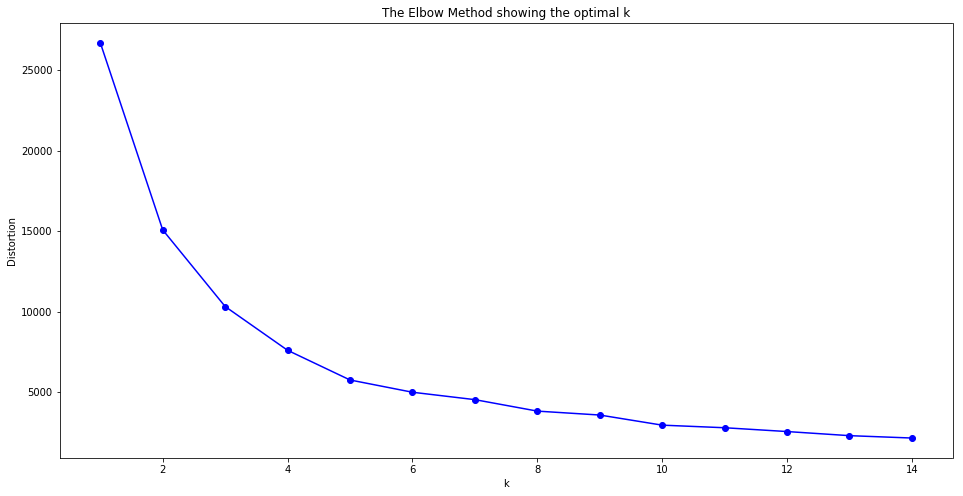

In [20]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bo-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The optimal number of cluster is 4.

In [21]:
kmeanModel = KMeans(n_clusters=4, n_init=25,random_state=10).fit(location_name[["PERCENT OF HOUSING CROWDED","PERCENT HOUSEHOLDS BELOW POVERTY", "PERCENT AGED 16+ UNEMPLOYED",
                                "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA","PERCENT AGED UNDER 18 OR OVER 64","PERCENT PER_CAPITA_INCOME"]])

I add a column which says the cluster of the area.

In [22]:
location_name.insert(0,"Cluster", kmeanModel.labels_);

In [23]:
location_name.groupby("Cluster").count()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,HARDSHIP_INDEX,LATITUDE,LONGITUDE,PERCENT PER_CAPITA_INCOME
Cluster,,,,,,,,,,,
0,15,15,15,15,15,15,15,15,15,15,15
1,19,19,19,19,19,19,19,19,19,19,19
2,14,14,14,14,14,14,14,14,14,14,14
3,22,22,22,22,22,22,22,22,22,22,22


In [24]:
location_name.groupby("Cluster").mean()

,COMMUNITY_AREA_NUMBER,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,HARDSHIP_INDEX,LATITUDE,LONGITUDE,PERCENT PER_CAPITA_INCOME
Cluster,,,,,,,,,,
0,24.466667,2.686667,15.680000,7.240000,8.620000,23.213333,13.666667,41.923232,-87.672249,1.858548
1,45.894737,4.705263,35.163158,24.042105,21.278947,40.926316,74.263158,41.780729,-87.638621,0.595431
2,44.500000,10.657143,22.935714,15.042857,39.100000,37.385714,74.928571,41.834985,-87.694490,0.584286
3,39.909091,3.322727,13.440909,13.277273,15.681818,37.795455,35.227273,41.831021,-87.691047,1.028572


We can see that cluster 0 consist of areas with high income, low hardship and good socioeconomical parameters. Clusters 1,2 are poor areas in which the harship index is high, and the income low. In cluster 1 there are more households in poverty and higher unemployment. Altough the per capita income is slightly higher than in the cluster 2.
Cluster 3 represents the middle class. Their average income is close to the average income of the city. 

The geographical distribution of the clusters is shown in the next map: 

In [25]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="chicago_crime")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [26]:
# create map
kclusters=4
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(location_name['LATITUDE'], location_name['LONGITUDE'], location_name['COMMUNITY_AREA_NAME'], location_name['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    

#Add a legend

legend_html =   '''
                <div style="position: fixed; 
                            bottom: 200px; right: 200px; width: 100px; height: 110px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Cluster <br>
                              &nbsp; 0 &nbsp; <i class="fa fa-circle" style="color:#ff0000"></i><br>
                              &nbsp; 1 &nbsp; <i class="fa fa-circle" style="color:#8000ff"></i><br>
                              &nbsp; 2 &nbsp; <i class="fa fa-circle" style="color:#2adddd"></i><br>
                              &nbsp; 3 &nbsp; <i class="fa fa-circle" style="color:#d4dd80"></i>
                </div>
                ''' 

map_clusters.get_root().html.add_child(folium.Element(legend_html))
       
map_clusters

The cluster 3 is scattered in all Chicago. The distribution is in accordance with the hypothesis that the cluster represents the middle class. The cluster 0 mainly represent areas within the downtown. The geographical differences in the other 2 clusters are harder to find, but in both of them are industrial complex.

# Popular venues in each community area

In [27]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['COMMUNITY_AREA_NAME'] = chicago_venues['COMMUNITY_AREA_NAME'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns];

In [28]:
chicago_venues_sum=chicago_onehot.groupby("COMMUNITY_AREA_NAME").sum().reset_index()

In [29]:
chicago_venues_sum=pd.merge(chicago_venues_sum,location_name[["Cluster", "COMMUNITY_AREA_NAME","COMMUNITY_AREA_NUMBER"]], on="COMMUNITY_AREA_NAME")
fixed_columns = [chicago_venues_sum.columns[-1],chicago_venues_sum.columns[-2]] + list(chicago_venues_sum.columns[:-2])
chicago_venues_sum = chicago_venues_sum[fixed_columns];

In [30]:
chicago_venues_cluster=chicago_venues_sum.groupby("Cluster").sum().reset_index();

In [31]:
chicago_venues_cluster=chicago_venues_cluster.drop(columns="COMMUNITY_AREA_NUMBER")

In [32]:
def return_most_common_venues(row, num_top_venues,inicio=1,):
    row_categories = row.iloc[inicio:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Cluster'] = chicago_venues_cluster["Cluster"]

for ind in np.arange(chicago_venues_cluster.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_venues_cluster.iloc[ind, 1:], num_top_venues)

area_venues_sorted.head()

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Coffee Shop,Mexican Restaurant,Bar,Pizza Place,Sandwich Place
1,1,Fast Food Restaurant,Park,Grocery Store,Bus Station,Discount Store
2,2,Mexican Restaurant,Bakery,Grocery Store,Pizza Place,Park
3,3,Grocery Store,Pizza Place,Indian Restaurant,Park,Bar


# Most common crime in a community area

In [34]:
# one hot encoding
chicago_crime_onehot = pd.get_dummies(crime_data[['PRIMARY_TYPE']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_crime_onehot['COMMUNITY_AREA_NUMBER'] = crime_data['COMMUNITY_AREA_NUMBER'] 

# move neighborhood column to the first column
fixed_columns = [chicago_crime_onehot.columns[-1]] + list(chicago_crime_onehot.columns[:-1])
chicago_crime_onehot = chicago_crime_onehot[fixed_columns];

In [35]:
chicago_crime_onehot.head(3)

,COMMUNITY_AREA_NUMBER,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
0,58.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,23.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
chicago_crime_sum=chicago_crime_onehot.groupby("COMMUNITY_AREA_NUMBER").sum().reset_index()

I add the name of the area, and the cluster information.

In [37]:
chicago_crime_sum.shape

(70, 36)

In [38]:
location_name.shape

(70, 12)

In [39]:
chicago_crime_cluster=pd.merge(chicago_crime_sum,location_name[["Cluster", "COMMUNITY_AREA_NAME","COMMUNITY_AREA_NUMBER"]], on="COMMUNITY_AREA_NUMBER")

In [40]:
fixed_columns = [chicago_crime_cluster.columns[-1],chicago_crime_cluster.columns[-2]] + list(chicago_crime_cluster.columns[:-2])
chicago_crime_cluster = chicago_crime_cluster[fixed_columns];

In [41]:
chicago_crime_cluster=chicago_crime_cluster.groupby("Cluster").sum()

In [42]:
chicago_crime_cluster=chicago_crime_cluster.drop(columns="COMMUNITY_AREA_NUMBER")

In [43]:
chicago_crime_cluster=chicago_crime_cluster.reset_index()

In [44]:
total_crime=[0,0,0,0]
for i in range(4):
    total_crime[i]=chicago_crime_cluster.loc[i][1:].sum()

In [45]:
chicago_crime_cluster["Total_crimes"]=total_crime

In [46]:
chicago_crime_cluster.head()

,Cluster,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Total_crimes
0,0,0,4,14,2,0,0,12,5,7,...,2,0,0,0,2,0,0,30,1,102
1,1,2,19,39,13,1,1,15,5,4,...,1,1,1,1,10,0,0,30,4,197
2,2,0,3,16,6,0,1,14,1,1,...,0,0,1,0,4,2,0,22,1,105
3,3,0,4,12,6,0,0,14,2,3,...,0,0,1,0,4,1,1,18,0,86


I will look for the most common crimes in each cluster.

In [47]:
crimes_cluster_0=return_most_common_venues(chicago_crime_cluster.iloc[0,:-1],5,0)
crime_0=pd.DataFrame(chicago_crime_cluster[crimes_cluster_0].loc[0,:])
crime_0=crime_0.rename(columns={0:"Cluster 0"})
crime_0.head()

,Cluster 0
THEFT,30
BATTERY,14
CRIMINAL DAMAGE,12
NARCOTICS,9
DECEPTIVE PRACTICE,7


In [48]:
crimes_cluster_1=return_most_common_venues(chicago_crime_cluster.iloc[1,:-1],5,0)
crime_1=pd.DataFrame(chicago_crime_cluster[crimes_cluster_1].loc[1,:])
crime_1=crime_1.rename(columns={1:"Cluster 1"})
crime_1.head()

,Cluster 1
BATTERY,39
THEFT,30
NARCOTICS,25
ASSAULT,19
CRIMINAL DAMAGE,15


In [49]:
crimes_cluster_2=return_most_common_venues(chicago_crime_cluster.iloc[2,:-1],5,0)
crime_2=pd.DataFrame(chicago_crime_cluster[crimes_cluster_2].loc[2,:])
crime_2=crime_2.rename(columns={2:"Cluster 2"})
crime_2.head()

,Cluster 2
THEFT,22
BATTERY,16
NARCOTICS,15
CRIMINAL DAMAGE,14
OTHER OFFENSE,9


In [50]:
crimes_cluster_3=return_most_common_venues(chicago_crime_cluster.iloc[3,:-1],5,0)
crime_3=pd.DataFrame(chicago_crime_cluster[crimes_cluster_3].loc[3,:])
crime_3=crime_3.rename(columns={3:"Cluster 3"})
crime_3.head()

,Cluster 3
THEFT,18
CRIMINAL DAMAGE,14
BATTERY,12
OTHER OFFENSE,7
BURGLARY,6


Among the 5 most common crimes in each cluster there are 8 categories between all clusters:
* Theft
* Battery
* Crimanl Damage
* Narcotics
* Other offense
* Burglary
* Assault
* Deceptive practice

I dismiss "Other offense" because is vague. I look correlations among the other offences and the venues in the community in which they were commited.

Theft is the most common crime in 3 clusters, and it is the second most common in the other. 

# Correlations in crime and venues

I am going to study the most common crimes individually and within clusters. For each of these crimes a score will be asigned to each venue category. The score is the sum of all the crimes that were commited in each community area. I expect that if the venue categories do not have an impact in crime, then the venue categories with the highest scores will correspond to the most popular categories in the cluster.

## Theft

I assign a score for each venues in a community area for theft.

In [51]:
chicago_venues_sum=chicago_venues_sum.sort_values(by="COMMUNITY_AREA_NUMBER");

In [52]:
chicago_venues_score=pd.DataFrame(columns=chicago_venues_sum.columns[3:])
for i in range(chicago_crime_sum.shape[0]):
    row=(chicago_crime_sum["THEFT"][i])*chicago_venues_sum.iloc[i,3:]
    chicago_venues_score=chicago_venues_score.append(row, ignore_index=True)

I add a the community area name, number and cluster to the dataframe of the scores.

In [53]:
chicago_venues_score["COMMUNITY_AREA_NAME"]=chicago_venues_sum["COMMUNITY_AREA_NAME"]
chicago_venues_score["COMMUNITY_AREA_NUMBER"]=chicago_venues_sum["COMMUNITY_AREA_NUMBER"]
chicago_venues_score["Cluster"]=chicago_venues_sum["Cluster"]
fixed_columns = [chicago_venues_score.columns[-1],chicago_venues_score.columns[-2],chicago_venues_score.columns[-3]] + list(chicago_venues_score.columns[:-3])
chicago_venues_score = chicago_venues_score[fixed_columns];

I group by cluster

In [54]:
chicago_venues_score[chicago_venues_score.columns[3:]]=chicago_venues_score[chicago_venues_score.columns[3:]].astype("int")

In [55]:
chicago_venues_score=chicago_venues_score.groupby("Cluster").sum()
chicago_venues_score=chicago_venues_score.drop(columns="COMMUNITY_AREA_NUMBER");

In [56]:
chicago_venues_score.head()

,ATM,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,2,2,2,2,6,0,0,0,...,0,0,0,0,0,6,0,0,0,0
1,0,0,0,0,0,0,5,4,0,0,...,0,7,0,0,2,0,0,0,0,0
2,1,0,0,0,0,0,3,0,0,4,...,0,1,0,0,0,0,2,0,0,1
3,5,3,0,0,0,0,14,0,0,0,...,4,6,5,0,0,1,5,5,8,8


Find the venues with the highest scores for each cluster

In [57]:
theft_cluster_0=return_most_common_venues(chicago_venues_score.iloc[0,:],5,0)
theft_0=pd.DataFrame(chicago_venues_score[theft_cluster_0].loc[0,:])
theft_0=theft_0.rename(columns={0:"Cluster 0"})
theft_0.head()

,Cluster 0
Bar,21
Fast Food Restaurant,15
Cocktail Bar,13
Rental Car Location,12
Park,10


In [58]:
theft_cluster_1=return_most_common_venues(chicago_venues_score.iloc[1,:],5,0)
theft_1=pd.DataFrame(chicago_venues_score[theft_cluster_1].loc[1,:])
theft_1=theft_1.rename(columns={1:"Cluster 1"})
theft_1.head()

,Cluster 1
Sandwich Place,32
Donut Shop,19
Discount Store,14
Fast Food Restaurant,13
Park,13


In [59]:
theft_cluster_2=return_most_common_venues(chicago_venues_score.iloc[2,:],5,0)
theft_2=pd.DataFrame(chicago_venues_score[theft_cluster_2].loc[2,:])
theft_2=theft_2.rename(columns={2:"Cluster 2"})
theft_2.head()

,Cluster 2
Mexican Restaurant,45
Coffee Shop,25
Sandwich Place,17
Hotel,16
Grocery Store,13


In [60]:
theft_cluster_3=return_most_common_venues(chicago_venues_score.iloc[3,:],5,0)
theft_3=pd.DataFrame(chicago_venues_score[theft_cluster_3].loc[3,:])
theft_3=theft_3.rename(columns={3:"Cluster 3"})
theft_3.head()

,Cluster 3
Mexican Restaurant,61
Coffee Shop,40
Pizza Place,33
Bakery,29
Grocery Store,25


I am going to create a dataframe with the data crime and venues.

In [63]:
chicago_crime_venues=pd.merge(chicago_venues_sum, chicago_crime_sum, on="COMMUNITY_AREA_NUMBER");

In [64]:
chicago_crime_venues.head()

,COMMUNITY_AREA_NUMBER,Cluster,COMMUNITY_AREA_NAME,ATM,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
0,1.0,0,Rogers Park,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,0
1,2.0,3,West Ridge,0,0,0,0,0,0,1,...,2,0,0,0,0,1,0,0,1,0
2,3.0,0,Uptown,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4.0,0,Lincoln Square,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5.0,0,North Center,0,0,0,0,0,0,2,...,0,0,0,0,0,1,0,0,1,0


In [68]:
chicago_venues_sum.shape

(70, 223)

In [66]:
correlation_crime=chicago_crime_venues.corr()

In [75]:
np.abs(correlation_crime["THEFT"][2:222]).sort_values(ascending=False)

Sandwich Place                   0.342396
Hotel                            0.313527
Hockey Arena                     0.283375
Donut Shop                       0.266725
Coffee Shop                      0.258426
Seafood Restaurant               0.255072
Japanese Restaurant              0.240540
Arts & Crafts Store              0.234139
Gastropub                        0.234139
Farmers Market                   0.234139
Dessert Shop                     0.219160
French Restaurant                0.219160
Spa                              0.218749
Cocktail Bar                     0.214740
Theater                          0.214410
Steakhouse                       0.208807
Boutique                         0.207337
Vegetarian / Vegan Restaurant    0.206114
Salad Place                      0.204030
Poke Place                       0.204030
Public Art                       0.204030
Stationery Store                 0.204030
Cafeteria                        0.204030
Food Court                       0